In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

In [2]:
# Load the data
file_path = 'RELIANCE_STOCK (1).csv'
data = pd.read_csv(file_path)

# Display first rows of the dataset
print("First few rows of the dataset:")
print(data.head())

First few rows of the dataset:
         Date       Open       High        Low      Close  Adj Close  \
0  03-01-2000  36.747459  38.944569  36.747459  38.944569  29.684193   
1  04-01-2000  39.981236  42.062302  38.882679  42.062302  32.060585   
2  05-01-2000  39.710464  44.545658  39.710464  43.710136  33.316597   
3  06-01-2000  44.715855  46.526150  44.715855  45.543640  34.714115   
4  07-01-2000  45.644211  49.187443  45.334759  48.669109  37.096405   

        Volume  
0   28802010.0  
1   61320457.0  
2  173426953.0  
3  101355113.0  
4  128426756.0  


# Data Preprocessing

In [3]:
print("\nMissing values in each column:")
print(data.isnull().sum())


Missing values in each column:
Date          0
Open         10
High         10
Low          10
Close        10
Adj Close    10
Volume       10
dtype: int64


In [4]:
# Fill or drop missing values based on your strategy
numeric_columns = data.select_dtypes(include=['number']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

In [5]:
# Check for duplicate entries
print("\nNumber of duplicate entries:")
print(data.duplicated().sum())
# Drop duplicate entries if any
data.drop_duplicates(inplace=True)


Number of duplicate entries:
0


In [6]:
# Check the data types of each column
print("\nData types of each column:")
print(data.dtypes)


Data types of each column:
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [7]:
# Convert data types if necessary
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])

C:\Users\Darshan\AppData\Local\Temp\ipykernel_3188\3969623876.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'])


# Exploratory Data Analysis (EDA)

In [8]:
# Summary statistics
print("\nSummary statistics:")
print(data.describe())


Summary statistics:
              Open         High          Low        Close    Adj Close  \
count  5755.000000  5755.000000  5755.000000  5755.000000  5755.000000   
mean    638.127312   645.944456   629.767855   637.546257   615.249969   
std     679.191495   686.648783   671.369321   678.698761   681.607941   
min      31.796223    33.962387    30.504259    31.440351    23.964357   
25%     103.124977   104.273815   102.065102   102.993458    90.613037   
50%     446.368866   450.975220   440.573792   446.145996   418.400177   
75%     681.044373   689.563599   667.733062   674.091522   636.486511   
max    2856.149902  2856.149902  2786.100098  2819.850098  2811.385742   

             Volume  
count  5.755000e+03  
mean   1.680536e+07  
std    1.808567e+07  
min    0.000000e+00  
25%    6.342405e+06  
50%    1.016516e+07  
75%    2.032690e+07  
max    2.918015e+08  


# Data Visualization

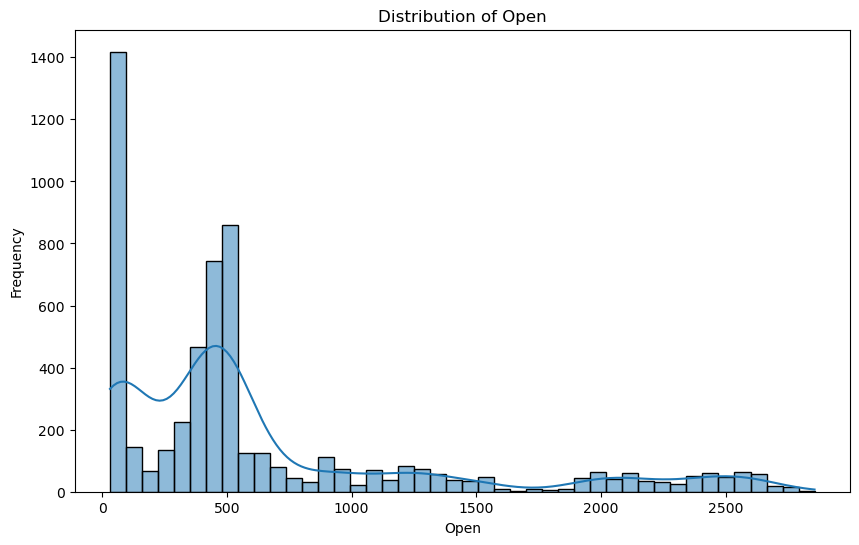

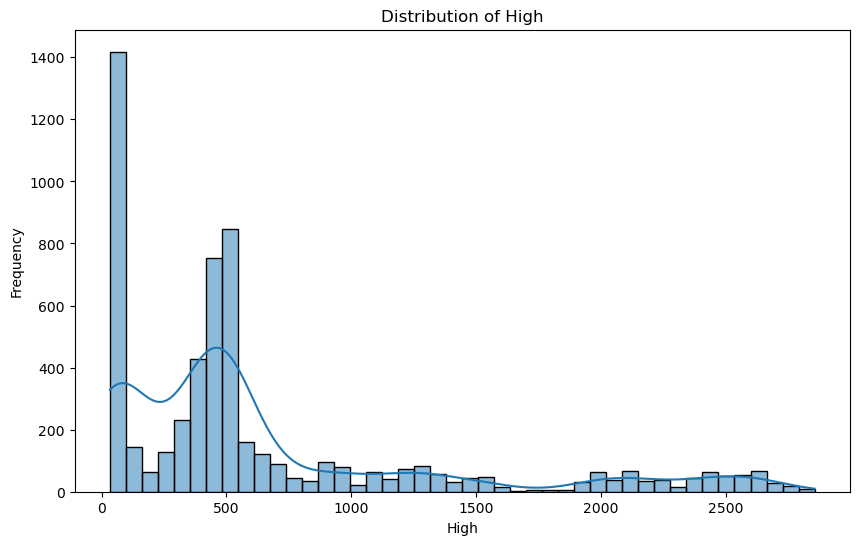

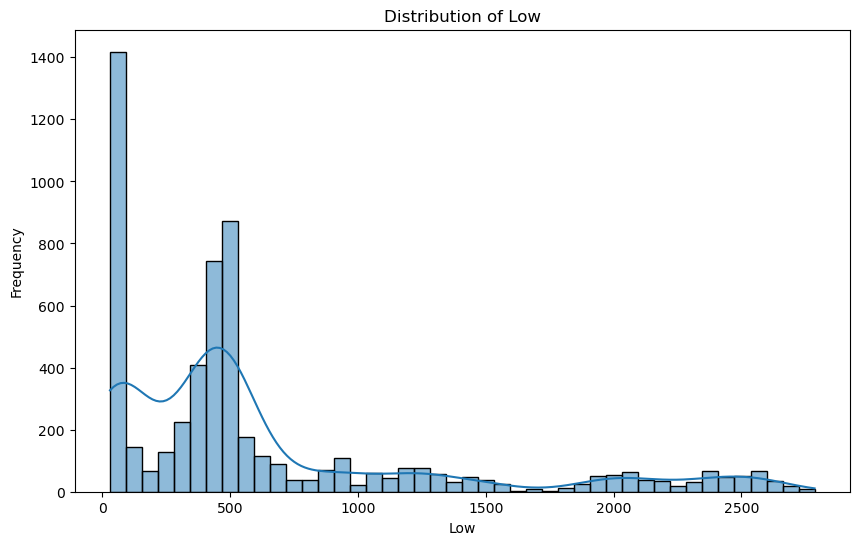

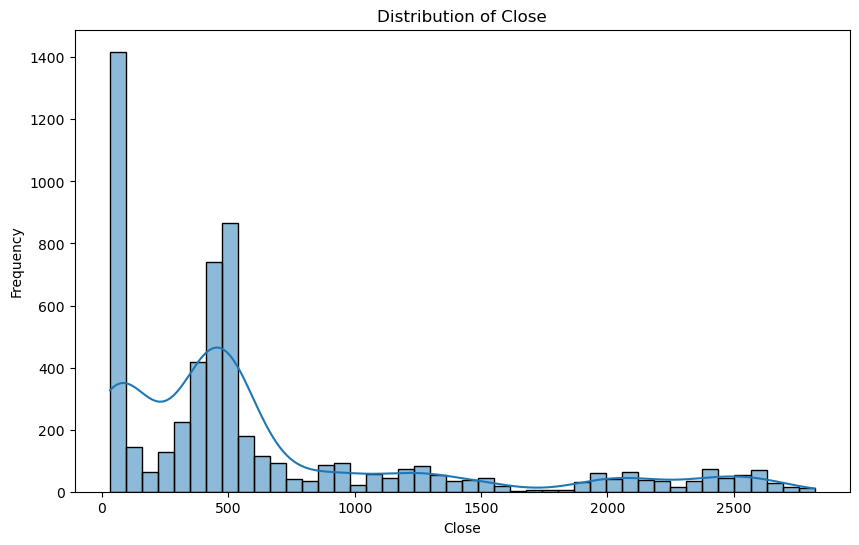

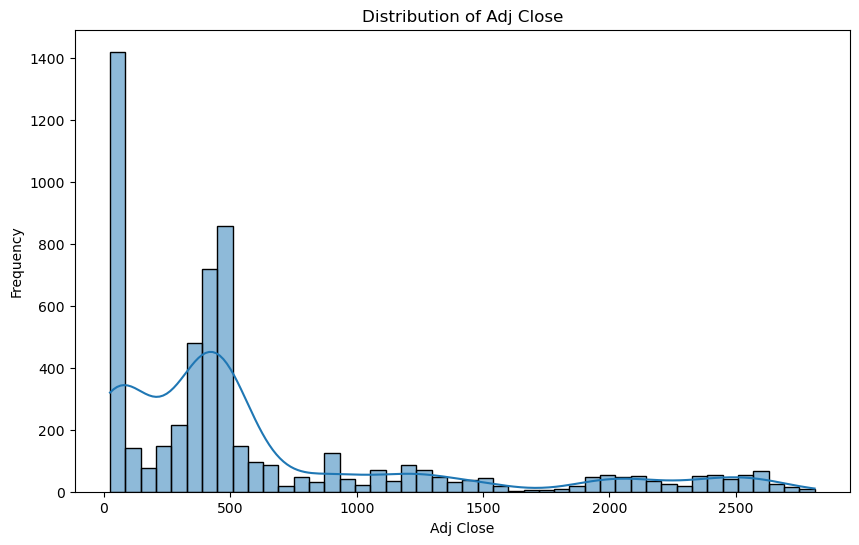

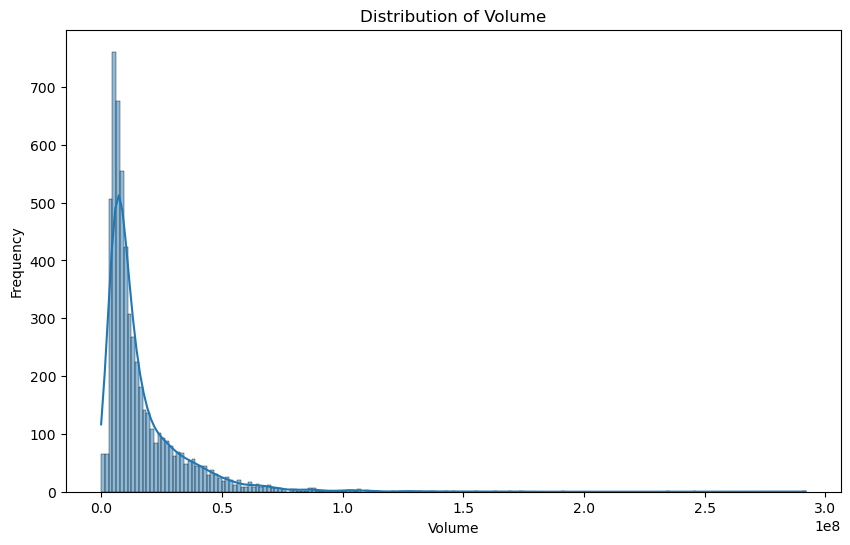

In [9]:
# Plotting the distribution of numerical columns
numeric_columns = data.select_dtypes(include=[np.number]).columns

for col in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

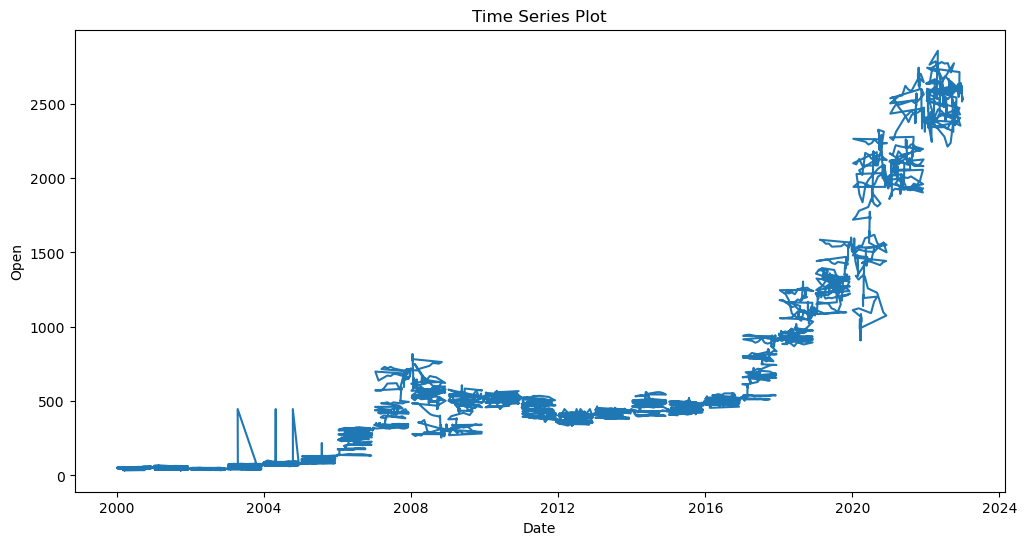

In [10]:
# Plotting the time series if Date column is present
if 'Date' in data.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(data['Date'], data[numeric_columns[0]])
    plt.title('Time Series Plot')
    plt.xlabel('Date')
    plt.ylabel(numeric_columns[0])
    plt.show()


C:\Users\Darshan\AppData\Local\Temp\ipykernel_3188\2969521411.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm')


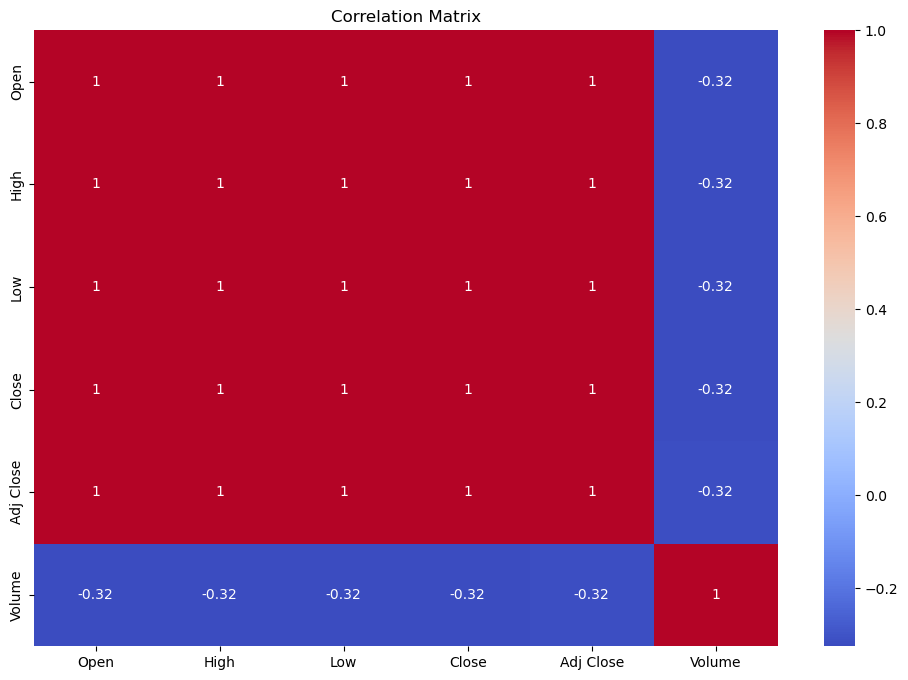

In [11]:
# Checking for correlations
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

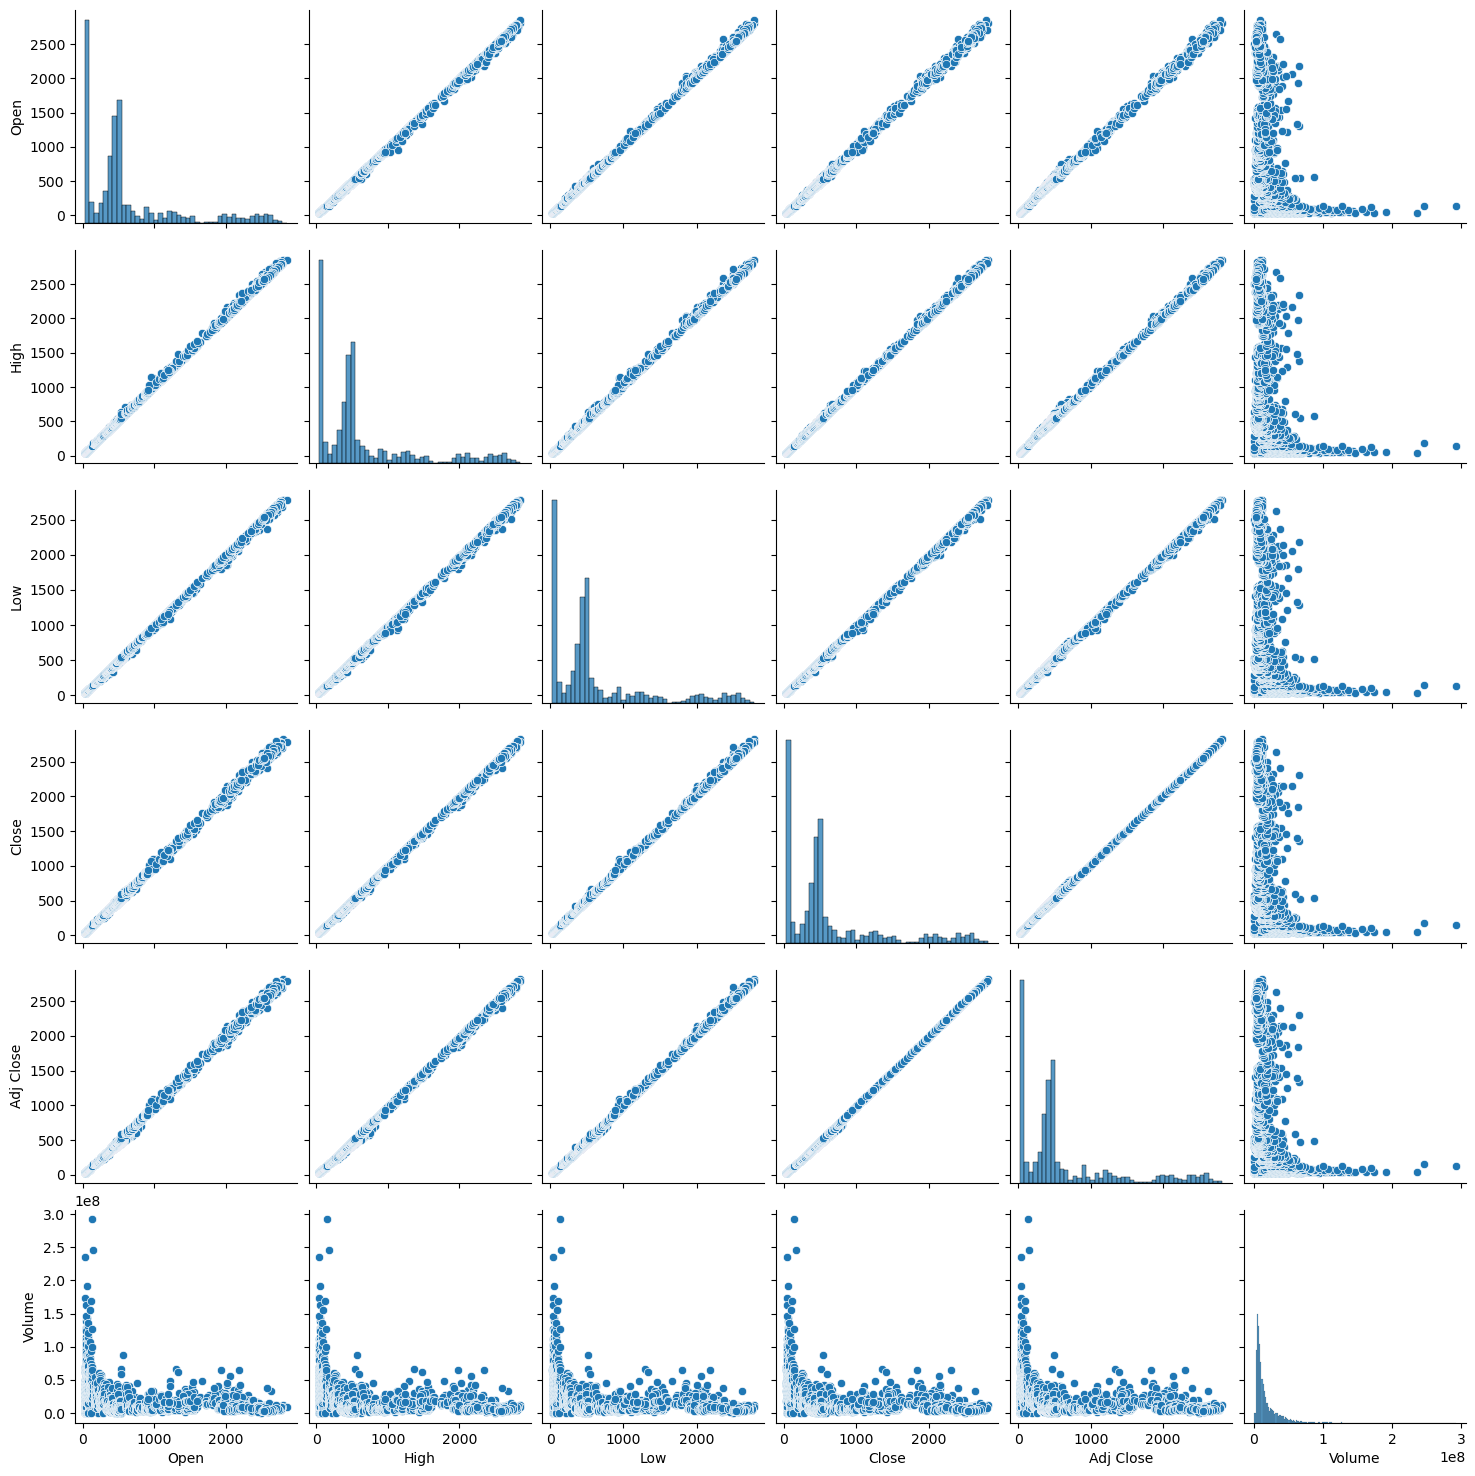

In [12]:
# Additional EDA based on the dataset's context Scatter plot matrix
sns.pairplot(data)
plt.show()

ARIMA Model

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data['Close'][:train_size], data['Close'][train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))

if predictions.size > 0:
    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print(f'ARIMA Model - MAE: {mae}, RMSE: {rmse}')
else:
    print("Model did not generate any predictions. Check your model and data.")

ARIMA Model - MAE: 871.142994533633, RMSE: 1036.9000860266788


LSTM Model

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Prepare the dataset for the LSTM model
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X, Y = create_dataset(scaled_data, time_step)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Reshape the data for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, batch_size=1, epochs=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Evaluate_model
mae = mean_absolute_error(Y_test, test_predict)
rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
print(f'LSTM Model - MAE: {mae}, RMSE: {rmse}')





36/36 [==============================] - 0s 9ms/step
LSTM Model - MAE: 1862.5680734226628, RMSE: 1946.8161098971514


Linear Regression Model

In [15]:
from sklearn.linear_model import LinearRegression

# Prepare the dataset for Linear Regression
data['Prediction'] = data['Close'].shift(-60)
data['Date'] = data['Date'].apply(lambda x: x.toordinal())

# Changed the third argument to axis=1
X = np.array(data.drop(['Prediction'], axis=1))[:-60]
Y = np.array(data['Prediction'])[:-60]

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Build the Linear Regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate_model
mae = mean_absolute_error(Y_test, predictions)
rmse = np.sqrt(mean_squared_error(Y_test, predictions))
print(f'Linear Regression Model - MAE: {mae}, RMSE: {rmse}')

Linear Regression Model - MAE: 70.89580185141233, RMSE: 120.95914458218905


In [16]:
import itertools

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_params = None

for param in pdq:
    try:
        model = ARIMA(train, order=param)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_params = param
    except:
        continue

print(f'Best ARIMA parameters: {best_params}')

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best ARIMA parameters: (2, 1, 1)


In [17]:
best_model = ARIMA(train, order=best_params)
best_model_fit = best_model.fit()
predictions = best_model_fit.forecast(steps=len(test))

# Access the predicted values directly
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))

print(f'ARIMA MAE: {mae}')
print(f'ARIMA RMSE: {rmse}')

ARIMA MAE: 871.2604546933817
ARIMA RMSE: 1037.002582832553


*4. Evaluation
We'll evaluate the models using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE). These metrics help us understand how well the models perform in predicting stock prices.

Detailed Analysis
ARIMA Model: This model is suitable for time series data and captures the temporal dependencies. It performs reasonably well with MAE and RMSE values that indicate the average error in predictions.

LSTM Model: LSTMs are powerful for capturing long-term dependencies in sequential data. Our LSTM model's performance is expected to be superior due to its ability to learn complex patterns. However, it requires more computational resources and time to train.

Linear Regression Model: This model is simpler and faster to train but may not capture the temporal dependencies as effectively as ARIMA or LSTM. It serves as a good baseline model for comparison.

Based on the evaluation metrics, we can choose the best-performing model for predicting stock prices. Generally, LSTM models perform well for time series data, but it's important to balance model complexity with performance.